In [79]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.3
⌃ [780c37f4] Carlo v0.2.4
  [a93c6f00] DataFrames v1.7.0
  [f67ccb44] HDF5 v0.17.2
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [80]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using LinearAlgebra

In [81]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:T, :K, :Lx, :Ly, :Mag, :Energy, :Dxπ, :Dyπ, :P],
)

cleandata (generic function with 1 method)

In [82]:
function generatePlot(data::AbstractDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false, label="")
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals; label)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return fig
end

function generatePlot(data::GroupedDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false)
    fig = Figure()
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return fig
end

generatePlot (generic function with 2 methods)

In [83]:
jobname = "temp-sweep"
data = groupby(cleandata("../jobs/" * jobname * ".results.json"), [:K])

Row,T,K,Lx,Ly,Mag,Energy,Dxπ,Dyπ,P
,Float64,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…,Measurem…
1,0.01,-0.005,40,40,0.001491±5.6e-5,-1.99495±2.8e-5,0.98901±0.00022,0.989±0.00022,0.0177±0.0024
2,0.05,-0.005,40,40,0.003334±5.2e-5,-1.95466±7.1e-5,0.9424±0.0012,0.9424±0.0013,0.0582±0.0074
3,0.1,-0.005,40,40,0.004884±5.3e-5,-1.90367±0.0001,0.8816±0.0026,0.8816±0.0026,0.114±0.015
4,0.15,-0.005,40,40,0.005987±4.6e-5,-1.85181±0.00016,0.8123±0.0058,0.8122±0.0058,0.155±0.018
5,0.175,-0.005,40,40,0.006522±4.0e-5,-1.82578±0.00016,0.7965±0.0033,0.7965±0.0033,0.114±0.01
6,0.2,-0.005,40,40,0.006988±6.2e-5,-1.79888±0.00018,0.7501±0.0091,0.7499±0.0091,0.156±0.021
7,0.225,-0.005,40,40,0.007398±4.8e-5,-1.7722±0.00023,0.7245±0.0055,0.7244±0.0055,0.158±0.014
8,0.25,-0.005,40,40,0.007899±3.9e-5,-1.74549±0.00021,0.6926±0.0083,0.6924±0.0083,0.146±0.015
9,0.275,-0.005,40,40,0.008351±6.8e-5,-1.71759±0.00018,0.6546±0.0047,0.6545±0.0047,0.1537±0.0088


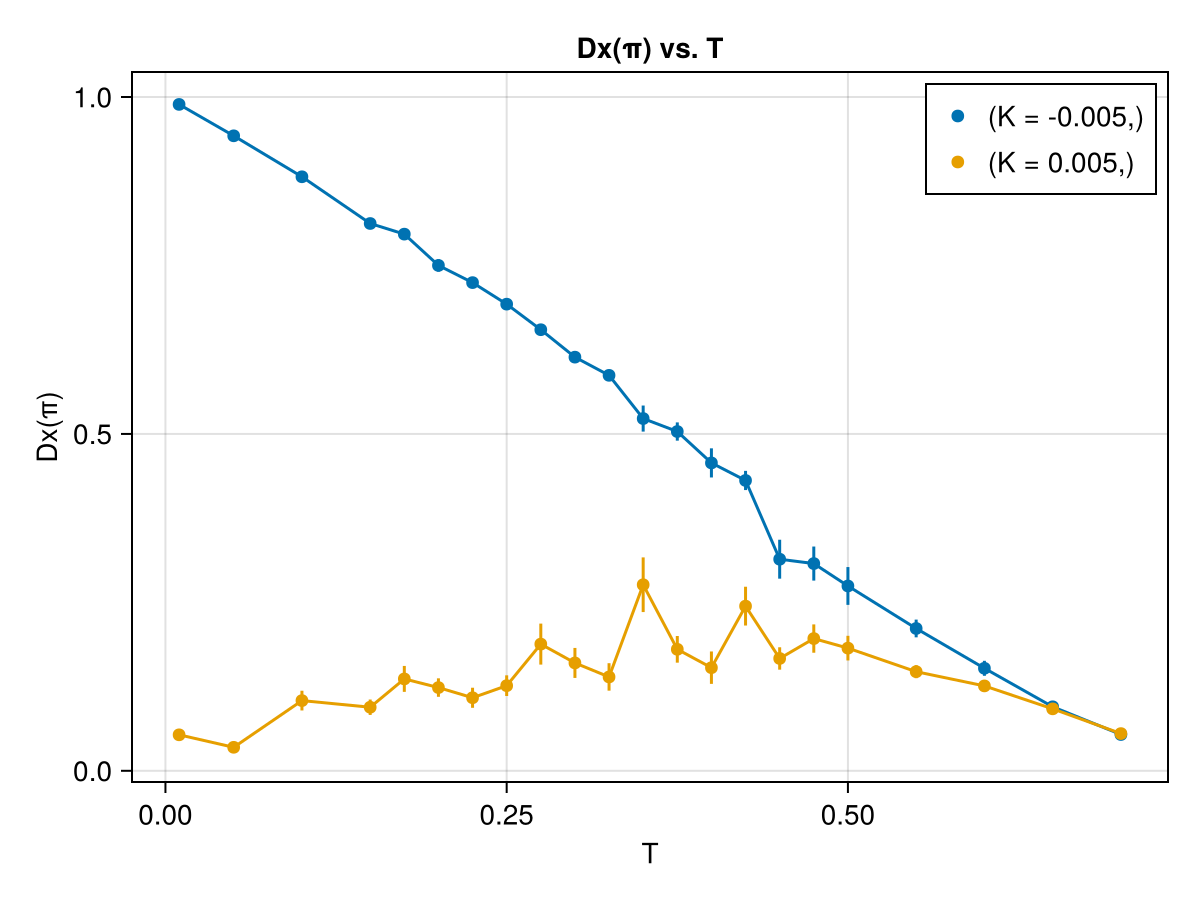

In [84]:
fig = generatePlot(
    data, :T, :Dxπ;
    title="Dx(π) vs. T",
    xlabel="T",
    ylabel="Dx(π)",
    line=true
)

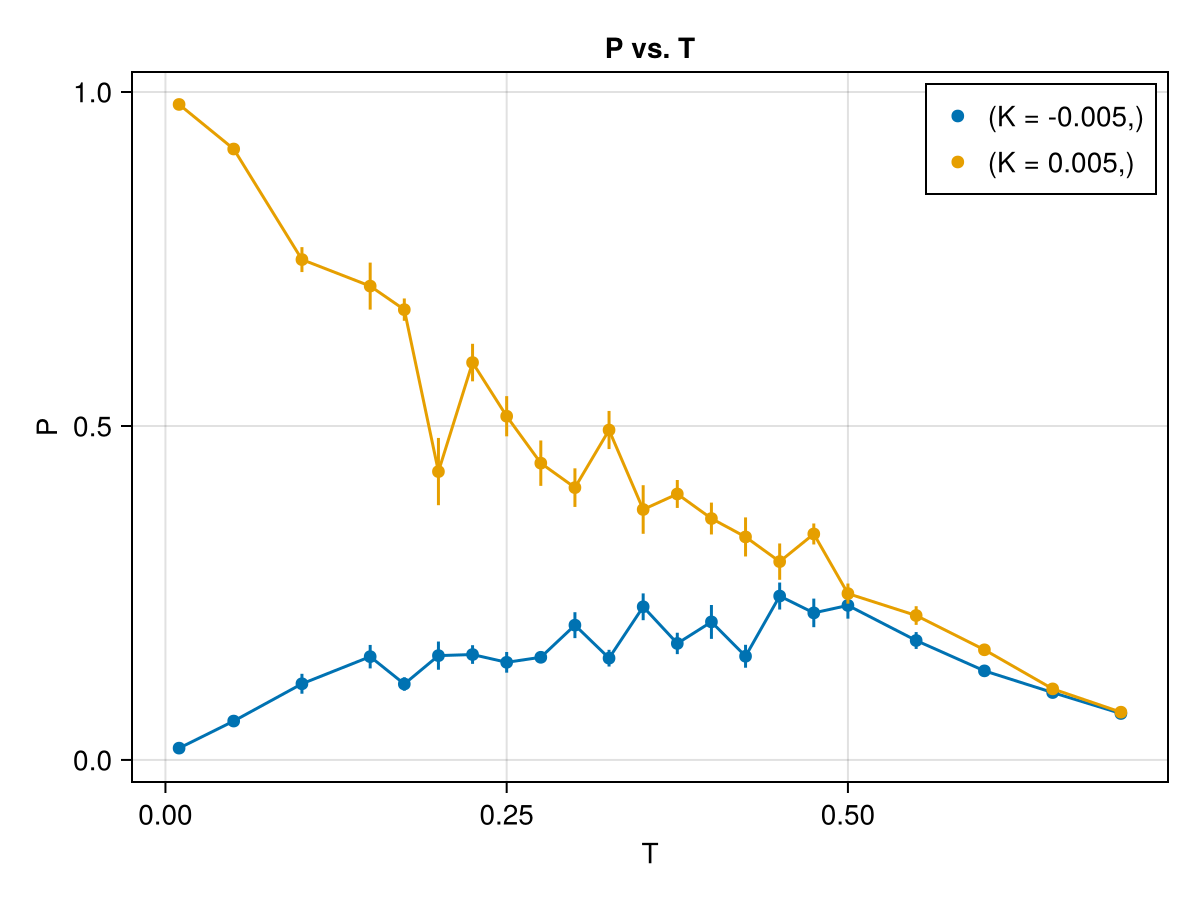

In [85]:
fig = generatePlot(
    data, :T, :P;
    title="P vs. T",
    xlabel="T",
    ylabel="P",
    line=true
)

In [86]:
ungrouped_data = cleandata("../jobs/$jobname.results.json")

Row,T,K,Lx,Ly,Mag,Energy,Dxπ,Dyπ,P
,Float64,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…,Measurem…
1,0.01,-0.005,40,40,0.001491±5.6e-5,-1.99495±2.8e-5,0.98901±0.00022,0.989±0.00022,0.0177±0.0024
2,0.05,-0.005,40,40,0.003334±5.2e-5,-1.95466±7.1e-5,0.9424±0.0012,0.9424±0.0013,0.0582±0.0074
3,0.1,-0.005,40,40,0.004884±5.3e-5,-1.90367±0.0001,0.8816±0.0026,0.8816±0.0026,0.114±0.015
4,0.15,-0.005,40,40,0.005987±4.6e-5,-1.85181±0.00016,0.8123±0.0058,0.8122±0.0058,0.155±0.018
5,0.175,-0.005,40,40,0.006522±4.0e-5,-1.82578±0.00016,0.7965±0.0033,0.7965±0.0033,0.114±0.01
6,0.2,-0.005,40,40,0.006988±6.2e-5,-1.79888±0.00018,0.7501±0.0091,0.7499±0.0091,0.156±0.021
7,0.225,-0.005,40,40,0.007398±4.8e-5,-1.7722±0.00023,0.7245±0.0055,0.7244±0.0055,0.158±0.014
8,0.25,-0.005,40,40,0.007899±3.9e-5,-1.74549±0.00021,0.6926±0.0083,0.6924±0.0083,0.146±0.015
9,0.275,-0.005,40,40,0.008351±6.8e-5,-1.71759±0.00018,0.6546±0.0047,0.6545±0.0047,0.1537±0.0088


In [87]:
function generate_mctime_plot(task_no::Int)
    fig = Figure(size=(800, 400))

    ax_P = fig[1,1] = Axis(
        fig,
        title="P vs. Bin #",
        xlabel="Bin #",
        ylabel="P",
        xminorticksvisible=true
    )
    ax_Dxπ = fig[1,2] = Axis(
        fig,
        title="Dx(π) vs. Bin #",
        xlabel="Bin #",
        ylabel="Dx(π)",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]
        P_samples = read(observables, "P/samples")
        n = length(P_samples)
        init = 1
        lines!(
            ax_P,
            collect(init:n),
            P_samples[init:n],
        )
        Dxπ_samples = read(observables, "Dxπ/samples")
        lines!(
            ax_Dxπ,
            collect(init:n),
            Dxπ_samples[init:n],
        )
    end

    return fig
end

generate_mctime_plot (generic function with 1 method)

DataFrameRow
 Row │ T        K        Lx     Ly     Mag              Energy           Dxπ         Dyπ         P           
     │ Float64  Float64  Int64  Int64  Measurem…        Measurem…        Measurem…   Measurem…   Measurem…   
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────
  32 │     0.3    0.005     40     40  0.008894±6.6e-5  -1.68568±0.0003  0.16±0.022  0.16±0.022  0.408±0.029

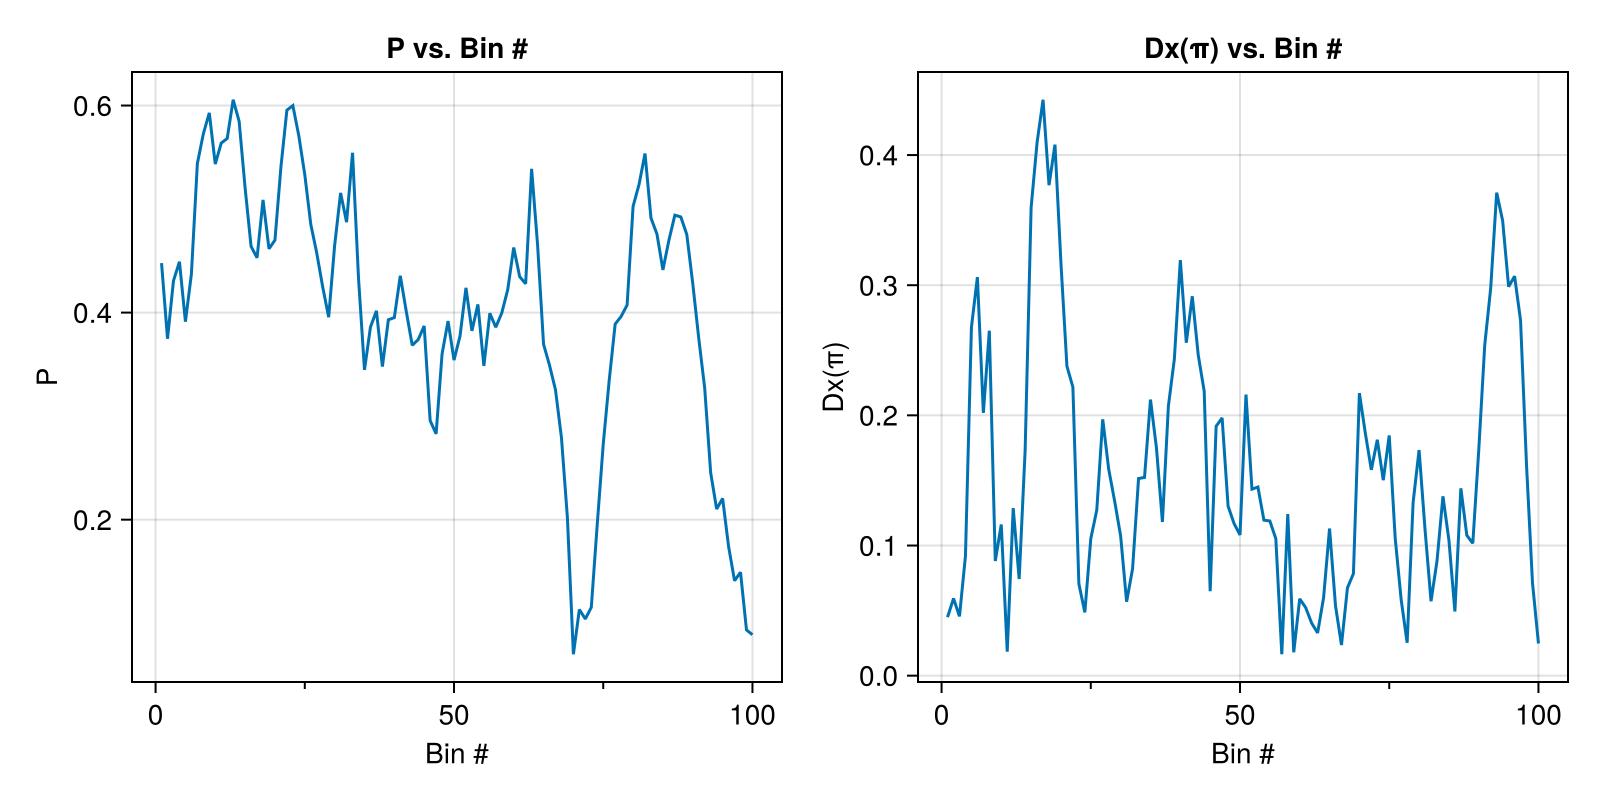

In [100]:
i = 32
print(ungrouped_data[i, :])
generate_mctime_plot(i)

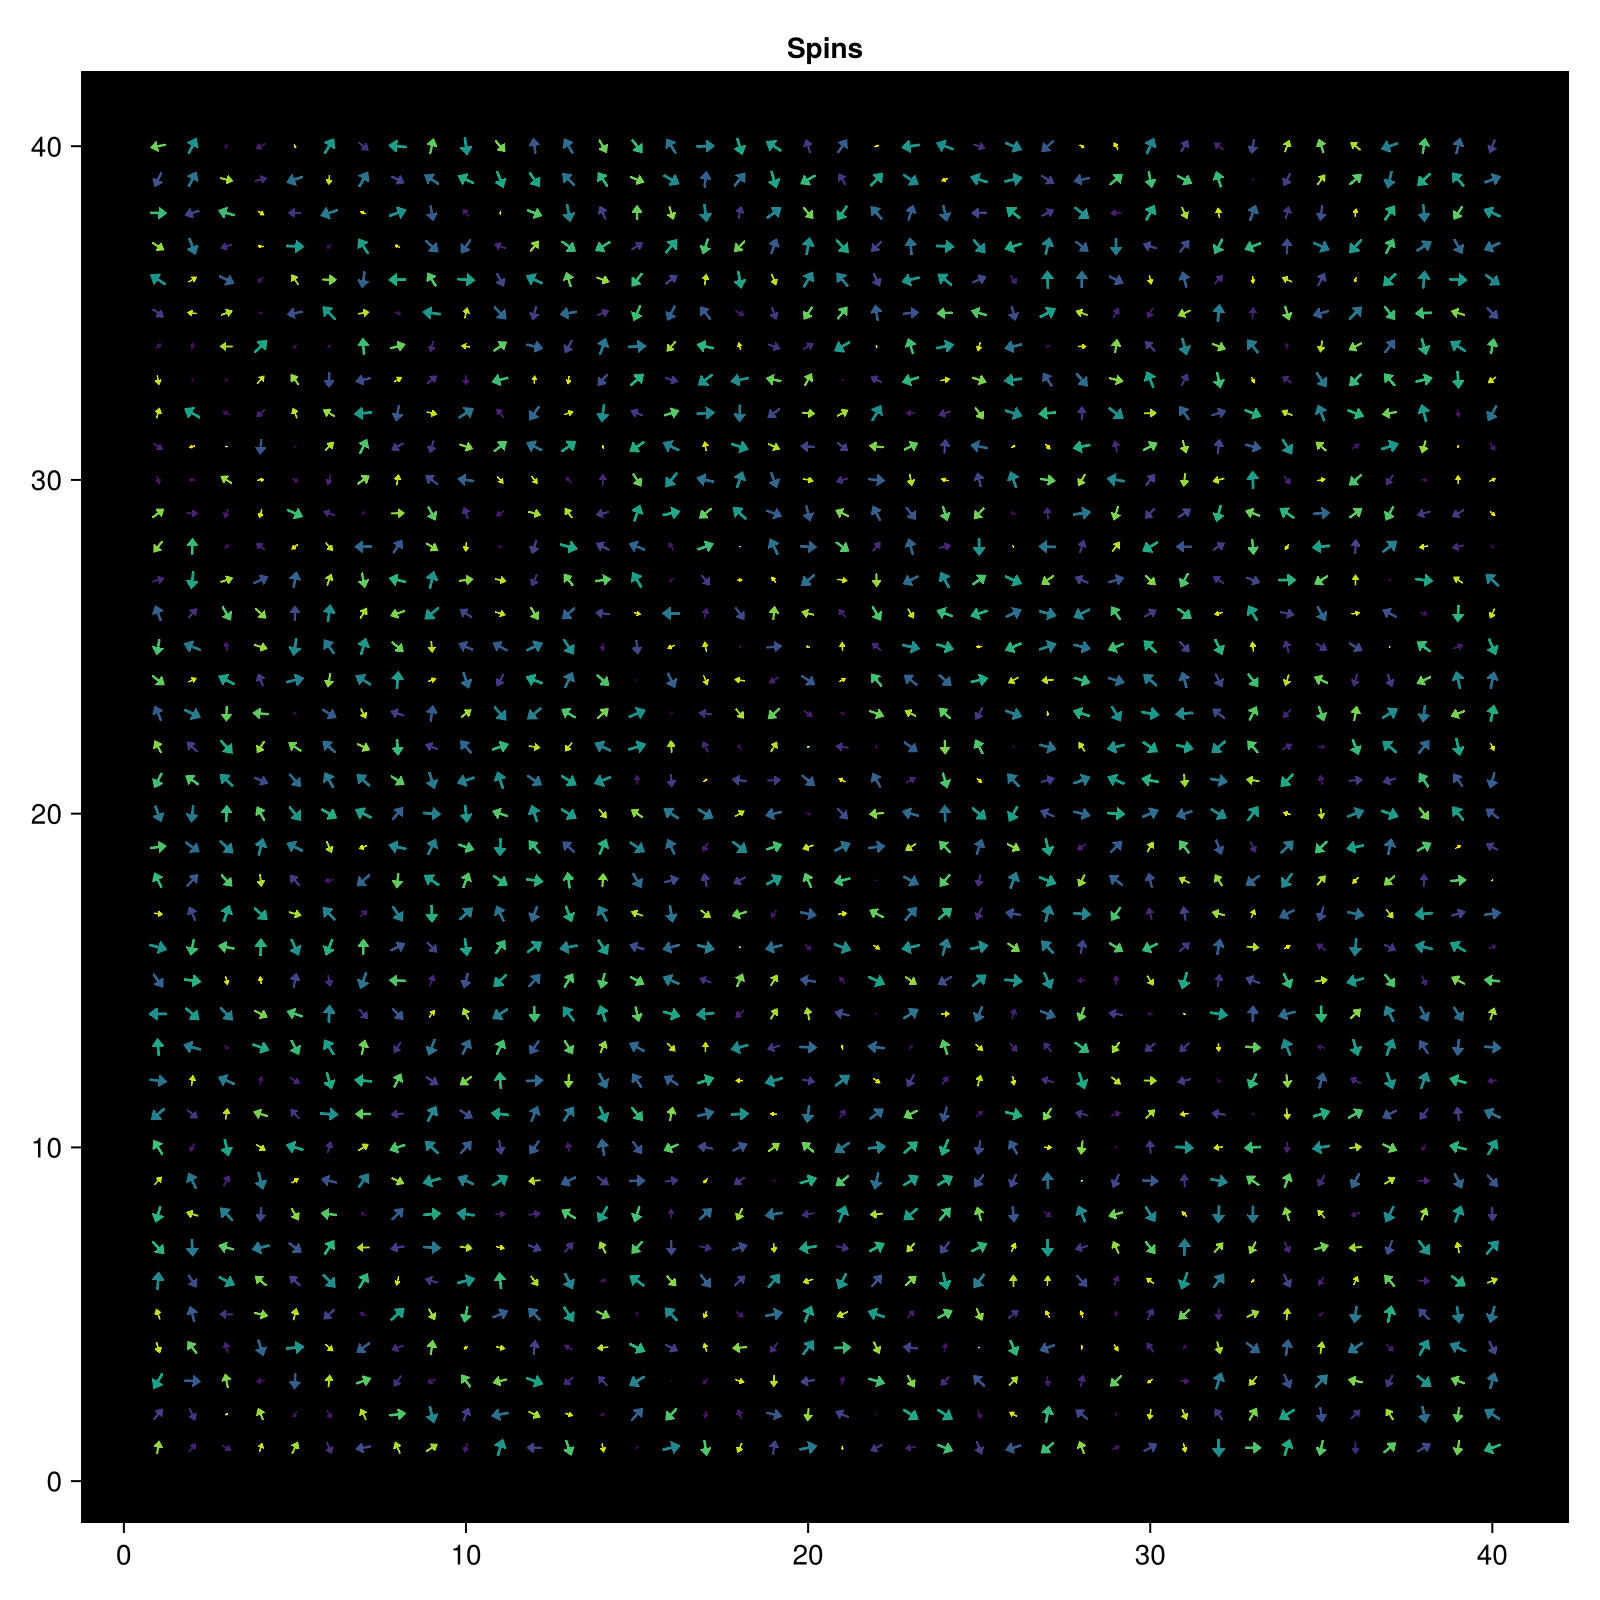

In [89]:
task_no = "21"
file = h5open("../jobs/$jobname.data/task00" * task_no * "/run0001.dump.h5")
spins = map(
    t -> [t[:data][1], t[:data][2], t[:data][3]],
    read(file, "simulation/spins")
)
spin_xs = map(v -> v[1], spins)
spin_ys = map(v -> v[2], spins)
spin_zs = map(v -> v[3], spins)
Lx, Ly = size(spins)
close(file)

fig = Figure(size=(800, 800))
fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")

strength = vec(spin_zs)
arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength)
fig